# Exploring chest x-ray models

The aim of this colab is to explore a few models trained on chest x-rays and qualitatively investigate their performance.


You can see a video accompanying this notebook [here](https://alistairewj.github.io).

First, we'll need to install a few packages. Of particular note are:

* [torchxrayvision](https://github.com/mlmed/torchxrayvision) - A library which harmonizes data loading for a few larger chest x-ray datasets and provides pretrained models. You can also [read a bit about their findings regarding cross-domain generalization](https://arxiv.org/abs/2002.02497).
* [grad-cam](https://github.com/jacobgil/pytorch-grad-cam) - a PyTorch based package for calculating saliency maps.

In [ ]:
!pip install torchxrayvision grad-cam ttach

In [ ]:
# import libraries
%matplotlib inline
import copy
import os
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_color_map
import cv2
from PIL import Image, ImageFilter
from collections import OrderedDict
import matplotlib as mpl

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.models import resnet50

import torchxrayvision as xrv

from pytorch_grad_cam import GradCAM
# Other methods available: ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

There are four large chest x-ray datasets of interest:

* [ChestXray14 (AKA ChestXray8)](https://nihcc.app.box.com/v/ChestXray-NIHCC) - 112,120 frontal-view X-ray images of 30,805 unique patients from the NIH clinical center. Images are associated with 14 NLP derived labels.
* [PadChest](https://bimcv.cipf.es/bimcv-projects/padchest/) - 160,000 images from 67,000 patients. Has extensive manual and machine learning derived labels.
* [CheXpert](https://stanfordmlgroup.github.io/competitions/chexpert/) - 224,316 chest radiographs from 65,240 patients with 14 NLP derived labels.
* [MIMIC-CXR](https://physionet.org/content/mimic-cxr/) - 377,110 images from 65,379 patients. The original dataset is provided with 227,835 deidentified free-text radiographic studies. For convenience, [a derived dataset with the same 14 labels as CheXpert is provided](https://physionet.org/content/mimic-cxr-jpg/).

While all the datasets are publicly available, only the ChestXray14 dataset is truly open data. CheXpert and PadChest are restricted access, requiring registration and signing of an agreement (albeit this process is instant).
Finally, MIMIC-CXR requires completion of a human subjects training course and applying on PhysioNet, a process which usually takes 1-2 weeks.

We'll use the sample data from PadChest (which does not require registration).

In [ ]:

# # download sample images from padchest

# # labels
# !gdown --id 10MYqI3rjUkrWCpvgJrryNpNSBSRtc45E

# # images
# !gdown --id 1FJ8T2lYCtTxtfhatpcXBpXvEBx9gTf81

# !mkdir -p /content/padchest
# !mv /content/chest_x_ray_images_labels_sample.csv /content/padchest/
# !mv /content/sample.zip /content/padchest/
# !unzip -qo /content/padchest/sample.zip -d /content/padchest/

# pc_path = Path('/content/padchest')
# labels = pd.read_csv(pc_path / 'chest_x_ray_images_labels_sample.csv')

# define a transform to convert images to 224x224

# # the dataset object from torchxrayvision
# d_pc = xrv.datasets.PC_Dataset(
#     imgpath=pc_path,
#     views=["PA","AP"],
#     unique_patients=False,
#     transform=tr
# )

# the dataset expects all images to be available, so we'll create a function to index it
# idx = d_pc.csv['ImageID'].str.startswith('216840111366964013829543166512013358092118761')
# idx = np.where(idx)[0][0]
# print(f'Found image at index {idx}.')
# sample = d_pc[idx]
# plt.imshow(sample['img'][0], cmap='Greys_r')
# plt.show()

As mentioned before, we'll use torchxrayvision to load a few example models.

In [7]:
#### Initiate the model
import copy
import os
from collections import OrderedDict
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_color_map
import cv2
from PIL import Image, ImageFilter
from collections import OrderedDict
import matplotlib as mpl
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import torchxrayvision as xrv
from pytorch_grad_cam import GradCAM
# Other methods available: ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from skimage.io import imread
import pydicom as dicom

def takemodel(models:OrderedDict,cams:OrderedDict,weights="mimic_ch"):
    """
        Define models and cams of each model; tools useful for heatmap
    Args:
        models (OrderedDict[xrv.models.DenseNet]): the CNN of the model
        cams (OrderedDict[GradCam]): Useful tool to make the heatmap
        weights (str): Name of the pretrained model weights
    """
    models[weights] = xrv.models.DenseNet(weights=weights)
    models[weights].eval()
    target_layer = models[weights].features[-2]
    cams[weights] = GradCAM(models[weights], target_layer, use_cuda=False)
    return models,cams
#### Read the image | Normalize
def normalize(sample, maxval):
    """
    Scales images to be roughly [-1024 1024].
     Args:
        image (dicom,jp,png): image
        maxval (int): maxvalue of the dicom image
        
    From torchxrayvision
    """
    
    if sample.max() > maxval:
        raise Exception("max image value ({}) higher than expected bound ({}).".format(sample.max(), maxval))
    
    sample = (2 * (sample.astype(np.float32) / maxval) - 1.) * 1024
    #sample = sample / np.std(sample)
    return sample


def extensionimages(image_path):

    if (str(image_path).find("jpg")!=-1) or (str(image_path).find("png")!=-1):

        # sample = Image.open("JPG_test/0c4eb1e1-b801903c-bcebe8a4-3da9cd3c-3b94a27c.jpg")
          sample = Image.open(image_path)
          return np.array(sample)
    if str(image_path).find("dcm")!=-1:
        img = dicom.dcmread(image_path).pixel_array
        print(True)
        return img
    else:
        return imread(image_path)


def read_image(image_path, tr=None,visualize=True):
    """
    Scales images to be roughly [-1024 1024].
     Args:
        image_path (str): path of the image    
    From torchxrayvision
    """
    img = extensionimages(image_path)
    ### If black image has 3 dim get just one channel
    

    try:
        img = img[:, :, 0]
    ### Otherwise we take 2 channels
    except IndexError:
        pass
    # img = resize(img, (img.shape[0] // 1.5, img.shape[1] // 1.5),
    #                 anti_aliasing=True)
    # print(img.shape)
    # Perform histogram equalization. (values between 0 and 255)
    # img = xrv.datasets.normalize(img, 255) 
    # img = cv2.equalizeHist(img.astype(np.uint8))
    img = ((img-img.min())/(img.max()-img.min())*255)
    ### Normalize to values -1024 1024
    img = normalize(img, 255)
    # print(img.min(),img.max())
    # Add color channel
    img = img[None, :, :]
    if tr is not None:                    
        img = tr(img)
    else:
        raise Exception("You should pass a transformer to downsample the images")
    return img

#### Applly colormap on image
def apply_colormap_on_image(org_im, activation, colormap_name, threshold=0.3,alpha=0.6):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image (224x224)
        activation_map (numpy arr): Activation map (grayscale) 0-255 (224x224)
        colormap_name (str): Name of the colormap (colormap_name)
        threshold (float): threshold at which to overlay heatmap (threshold that anomaly must surpass in terms of probability)
        alpha (float): adjust the intense in which the model predicts
    Original source: https://github.com/utkuozbulak/pytorch-cnn-visualizations

    Added thresholding to activations.
    """
    ### Grayscale_cam
    grayscale_cam = copy.deepcopy(activation)
    # Get colormap just color type
    color_map = mpl_color_map.get_cmap(colormap_name)
    # Like map the activation function to the color map
    
    no_trans_heatmap = color_map(activation)
    ### Not_trans_heatmap output (224x224x4 channels) (HSV-alpha channels)
    ### H --> channel 0 H --> channel 1 H --> channel 2 alpha --> channel 3
    
    # Change alpha channel in colormap to make sure original image is displayed deepcopy
    alpha_channel = 3
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, alpha_channel] = alpha

    # set to fully transparent if there is a very low activation (if the activation map is lower than the threshold)
    idx = (grayscale_cam <= threshold)
    # convert to a 3d index the shape of the image (expand the image by arrays) 
    # Input shape 224x244 --- Output Shape 224x224x1
    ignore_idx = np.expand_dims(np.zeros(grayscale_cam.shape, dtype=bool), 2)
    # print(idx.shape)
    ### Idx is the four fimenation of the heatmap concatenate 224x224x3 with 224x224x1 ---> 224x224x4
    idx = np.concatenate([ignore_idx]*3 + [np.expand_dims(idx, 2)], axis=2)
    
    # print(heatmap.shape)
    heatmap[idx] = 0
    ### Inputs 224x224x4 
    ### Scale to a 255 integer and map to PIL image
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    ### Color map activation scale to 255 PIL image
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))
    
    # Apply heatmap on image
    ### Create and RGBA image
    heatmap_on_image = Image.new("RGBA", org_im.size)
    ### org_im PIL converted onto RGBA and overlapped with heatmap on image
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    ### heatmap_on_image overlap with heatmap
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image   



def heatmap_core(image:np.array,pathologies:list,target:str,model_cmaps:list,threshold = 0.3, alpha = 0.8,obscureness = 0.8,fontsize=14)->plt:
    """
    Returns the heatmap of the image
     Args:
        image (np.array): Numpy Array Image (224x224)
        target (str): Pathology to select
        model_cmaps (list): colors to heatmap
        pathologies(list): List of pathologies
        threshold (float): Threshold to be more exigent or less exigent with the zone in which you are looking for
        alpha (float): the higher this value, the more intense is the colormaps
        obscureness (float) : the mhigher is this value the darker are the color maps
        fontsize (float): adjust the fontsize of the plot
    Original source: https://github.com/utkuozbulak/pytorch-cnn-visualizations
    Modifications by : ### TeamMIMICIV  

    Added thresholding to activations.
    """
    assert target  in pathologies,"Pathology input not in pathology maps"
    #### Initializing models 
    models = OrderedDict()
    cams = OrderedDict()
    for model_name in ['densenet121-res224-mimic_nb', 'densenet121-res224-mimic_ch']:
      #### Adding the models and cams to the OrderedDict structure
      models,cams = takemodel(models,cams,weights=model_name)
    ### Get an image
    input_tensor = torch.from_numpy(image).unsqueeze(0)

    img = input_tensor.numpy()[0, 0, :, :]
    img = (img / 1024.0 / 2.0) + 0.5
    img = np.clip(img, 0, 1)
    img = Image.fromarray(np.uint8(img * 255) , 'L')

    # using the variable axs for multiple Axes
    plt.figure(figsize=(10, 8))
    print(f'\nLooking for {target}.')
    i = 0
    for model_name, model in models.items():
      # get our model performance
      with torch.no_grad():
          out = model(input_tensor).cpu()
        
      # reshape the dataset labels to match our model
      # xrv.datasets.relabel_dataset(model.pathologies, d_pc)

      # finds the index of the target based on the model pathologies
      
      target_category = model.pathologies.index(target)
      grayscale_cam = cams[model_name](input_tensor=input_tensor, target_category=target_category)
      # In this example grayscale_cam has only one image in the batch:
      grayscale_cam = grayscale_cam[0, :]

      _, img = apply_colormap_on_image(img, grayscale_cam, model_cmaps[i].name, threshold=threshold,alpha=alpha)

      # add plot to add the color to the axis
      plt.plot(0, 0, '-', lw=6, color=model_cmaps[i](0.7), label=model_name)

      # what did we predict?
      prob = np.round(out[0].detach().numpy()[target_category], 4)
      print(f'  {model_name}: prob {prob:0.3f}')
      i += 1

    plt.legend(fontsize=fontsize)
    plt.imshow(img, cmap='bone')
    plt.axis('off')
    # plt.show()
    return plt


def heatmap(imgpath,target,threshold = 0.3, alpha = 0.8,obscureness = 0.8,fontsize=14):
    """
    Returns the heatmap of the image
     Args:
        imgpath (str): Name of the image path 
        target (str): Pathology to select
       
        threshold (float): Threshold to be more exigent or less exigent with the zone in which you are looking for
        alpha (float): the higher this value, the more intense is the colormaps
        obscureness (float) : the mhigher is this value the darker are the color maps
        fontsize (float): adjust the fontsize of the plot
    Original source: https://github.com/utkuozbulak/pytorch-cnn-visualizations
    Modifications by : ### TeamMIMICIV  
    Added thresholding to activations.
    """
    pathologies = ['Atelectasis', 'Consolidation', 'Pneumothorax','Edema', 'Effusion', 'Pneumonia', 'Cardiomegaly']
    model_cmaps = [mpl_color_map.Purples, mpl_color_map.Greens_r]
    tr = transforms.Compose(
        [xrv.datasets.XRayCenterCrop(), xrv.datasets.XRayResizer(224, engine='cv2')]
    )
    image = read_image(imgpath,tr=tr)
    return heatmap_core(image,pathologies,target,model_cmaps,threshold = threshold, alpha = alpha,obscureness = obscureness,fontsize=fontsize).show()


if __name__=="__main__":
    imgpath ="""Path to select"""
    # pathologies = ['Atelectasis', 'Consolidation', 'Pneumothorax','Edema', 'Effusion', 'Pneumonia', 'Cardiomegaly']   
    target = """Select pathology you want"""
    heatmap(imgpath,target)

Setting XRayResizer engine to cv2 could increase performance.
True

Looking for Pneumothorax.
  densenet121-res224-mimic_nb: prob 0.068
  densenet121-res224-mimic_ch: prob 0.501


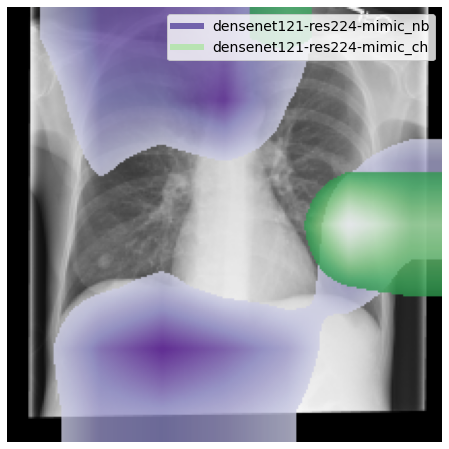

In [9]:
# load a model trained on jfhealthcare
# !wget https://raw.githubusercontent.com/jfhealthcare/Chexpert/master/config/example.json -O /usr/local/lib/python3.7/dist-packages/torchxrayvision/baseline_models/jfhealthcare/config/example.json
# !wget https://github.com/mlmed/torchxrayvision/releases/download/v1/baseline_models_jfhealthcare-DenseNet121_pre_train.pth -O /usr/local/lib/python3.7/dist-packages/torchxrayvision/baseline_models/jfhealthcare/baseline_models_jfhealthcare-DenseNet121_pre_train.pth
# model = xrv.baseline_models.jfhealthcare.DenseNet()
target = 'Cardiomegaly'


# pathologies = ['Atelectasis', 'Consolidation', 'Pneumothorax','Edema', 'Effusion', 'Pneumonia', 'Cardiomegaly']   
heatmap( os.listdir()[1],"Pneumothorax")


We'll define a function that, given an activation map, overlays the map on the original x-ray.

With that out of the way, let's look at the activation on a few choice images!

In [ ]:
# pc_image_ids = [f for f in os.listdir(pc_path) if f.endswith('.png')]
# # only include samples in the dataset object - leaves us 15 images
# pc_image_ids = [f for f in pc_image_ids if f in set(d_pc.csv['ImageID'].values)]

Setting XRayResizer engine to cv2 could increase performance.
True

Looking for Atelectasis.
  densenet121-res224-mimic_nb: prob 0.035
  densenet121-res224-mimic_ch: prob 0.050


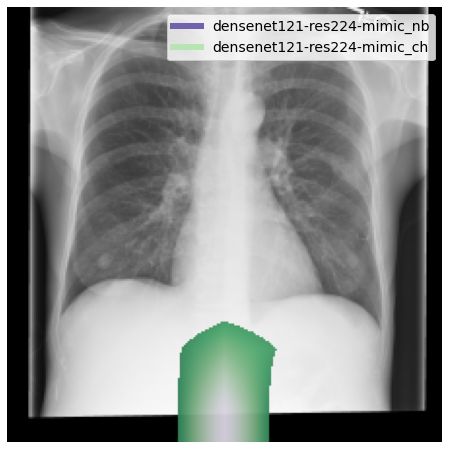

In [ ]:
# choose which image
# image_id = pc_image_ids[0]
# img = dicom.dcmread("example.dcm").pixel_array
# img.astype(int)
# img = normalize(img)
# choose which pathology
# if None is put here, the most probable label is used
# options: 'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
# 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
# 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia',
# target_category = model.pathologies.index('Enlarged Cardiomediastinum')


tr = transforms.Compose(
    [xrv.datasets.XRayCenterCrop(), xrv.datasets.XRayResizer(224, engine='cv2')]
)
img = read_image("example.dcm",tr=tr)

target = 'Pneumonia'

# idx_sample = get_image_index(d_pc, pc_image_ids[0])
# sample = d_pc[idx_sample]

input_tensor = torch.from_numpy(img).unsqueeze(0)

# using the variable axs for multiple Axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
axs = (ax1, ax2, ax3, ax4)

i = 0
for model_name, model in models.items():
  # get our model performance
  with torch.no_grad():
      out = model(input_tensor).cpu()

  # finds the index of the target based on the model pathologies
  target_category = model.pathologies.index(target)

  grayscale_cam = cams[model_name](input_tensor=input_tensor, target_category=target_category)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]

  img = input_tensor.numpy()[0, 0, :, :]
  img = scaleshift(img)
  # img = (img / 1024.0 / 2.0) + 0.5
  # img = np.clip(img, 0, 1)
  # img = Image.fromarray(np.uint8(img * 255) , 'L')
  _, heatmap_on_image = apply_colormap_on_image(img, grayscale_cam, 'cool', threshold=0.3)

  axs[i].imshow(heatmap_on_image, cmap='bone')

  # what did we predict?
  prob = np.round(out[0].detach().numpy()[target_category], 4)

  axs[i].set_title(f'{model_name}: prob {prob:0.3f}')

  i += 1
plt.axis('off')
plt.show()

When looking for the cardiomegaly label, we immediately see that the CheXpert and MIMIC-CXR trained models are looking outside the chest-wall, particularly at the top corners where often text information is written.

We can look at other images with known findings and see how the models compare.

In [ ]:
for i, p in enumerate(pc_image_ids):
  idx = d_pc.csv['ImageID'] == p
  print(i, p)
  print(d_pc.csv.loc[idx, 'Labels'].values[0])

In [ ]:
# choose which image
# image_id = pc_image_ids[5]
# print(image_id)
# print(d_pc.csv.loc[d_pc.csv['ImageID'] == image_id, 'Labels'].values[0])
img = dicom.dcmread("example.dcm").pixel_array
img.astype(int)
img = transform(img)


input_tensor = torch.from_numpy(img).unsqueeze(0)
target = 'Cardiomegaly'
# choose which pathology

# using the variable axs for multiple Axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
axs = (ax1, ax2, ax3, ax4)

print(f'\nLooking for {target}.')
i = 0
for model_name, model in models.items():
  # get our model performance
  with torch.no_grad():
      out = model(input_tensor).cpu()
    
  # reshape the dataset labels to match our model
  # xrv.datasets.relabel_dataset(model.pathologies, d_pc)

  # finds the index of the target based on the model pathologies
  target_category = model.pathologies.index(target)
  img = input_tensor.numpy()[0, 0, :, :]
  img = (img / 1024.0 / 2.0) + 0.5
  img = np.clip(img, 0, 1)
  img = Image.fromarray(np.uint8(img * 255) , 'L')

  grayscale_cam = cams[model_name](input_tensor=input_tensor, target_category=target_category)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]

  _, heatmap_on_image = apply_colormap_on_image(img, grayscale_cam, 'cool', threshold=0.4)

  axs[i].imshow(heatmap_on_image, cmap='bone')

  # what did we predict?
  prob = np.round(out[0].detach().numpy()[target_category], 4)

  axs[i].set_title(f'{model_name}: prob {prob:0.3f}')
  axs[i].axis('off')
  i += 1

plt.show()

Again we can see some unusual behaviour from the models - only the one derived from MIMIC-CXR is actually highlighting areas within the lungs.

We can look at these saliency maps all on the same figure for better comparison.

In [ ]:
# choose which image
img = dicom.dcmread("example.dcm").pixel_array
img.astype(int)
img = transform(img)


input_tensor = torch.from_numpy(img).unsqueeze(0)
# target = 'Cardiomegaly'

# choose which pathology
# if None is put here, the most probable label is used
# options: 'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
# 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
# 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia',
# target_category = model.pathologies.index('Enlarged Cardiomediastinum')
target = 'Pneumonia'

# idx_sample = get_image_index(d_pc, pc_image_ids[0])
# sample = d_pc[idx_sample]

# input_tensor = torch.from_numpy(sample["img"]).unsqueeze(0)
img = input_tensor.numpy()[0, 0, :, :]
img = (img / 1024.0 / 2.0) + 0.5
img = np.clip(img, 0, 1)
img = Image.fromarray(np.uint8(img * 255) , 'L')

# using the variable axs for multiple Axes
plt.figure(figsize=(10, 8))

print(f'\nLooking for {target}.')
i = 0
for model_name, model in models.items():
  # get our model performance
  with torch.no_grad():
      out = model(input_tensor).cpu()
    
  # reshape the dataset labels to match our model
  # xrv.datasets.relabel_dataset(model.pathologies, d_pc)

  # finds the index of the target based on the model pathologies
  target_category = model.pathologies.index(target)

  grayscale_cam = cams[model_name](input_tensor=input_tensor, target_category=target_category)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]

  _, img = apply_colormap_on_image(img, grayscale_cam, model_cmaps[i].name, threshold=0.4)


# axs[i].imshow(heatmap_on_image, cmap='bone')

  # add plot to add the color to the axis
  plt.plot(0, 0, '-', lw=6, color=model_cmaps[i](0.4), label=model_name)

  # what did we predict?
  prob = np.round(out[0].detach().numpy()[target_category], 4)
  print(f'  {model_name}: prob {prob:0.3f}')
  i += 1

plt.legend(fontsize=14)
plt.imshow(img, cmap='bone')
plt.axis('off')
plt.show()

## Try it with an image from the internet!

OpenI is a search engine provided by the National Library of Medicine for medical images (mostly sourced from public articles, but some datasets exist). In particular, Indiana University released a chest x-ray dataset of ~4000 images with reports, which we can play around with.

1. Go to: https://openi.nlm.nih.gov/gridquery?sub=x&m=1&n=100&it=xg
2. Click an image
3. Right click the image, and click "Copy Link Address"
4. Put the image address below, and see how the model do!

In [ ]:

import subprocess
from skimage.io import imread

def normalize(sample, maxval):
    """
    Scales images to be roughly [-1024 1024].
    From torchxrayvision
    """
    
    if sample.max() > maxval:
        raise Exception("max image value ({}) higher than expected bound ({}).".format(sample.max(), maxval))
    
    sample = (2 * (sample.astype(np.float32) / maxval) - 1.) * 1024
    #sample = sample / np.std(sample)
    return sample

def read_image(image_path, tr=None):
  img = imread(image_path)
  img = img[:, :, 0]

  # Perform histogram equalization.
  img = cv2.equalizeHist(img.astype(np.uint8))
  img = normalize(img, 255)
  print(img.max())
  # Add color channel
  img = img[None, :, :]
  if tr is not None:                    
    img = tr(img)
  
  return img

def download_xray(image_link, image_name='downloaded-xray', tr=tr):
  """Download a chest x-ray and transform it."""
  # download the image to the filename provided
  subprocess.call(['wget', '-N', image_link, '-O', image_name])

  image = read_image(image_name, tr=tr)

  return image

In [ ]:
image_link = 'https://openi.nlm.nih.gov/imgs/512/1/1/CXR1_1_IM-0001-4001.png?keywords=normal'
target = 'Pneumonia'
image = download_xray(image_link, image_name='downloaded-xray', tr=tr)

input_tensor = torch.from_numpy(image).unsqueeze(0)

img = input_tensor.numpy()[0, 0, :, :]
img = (img / 1024.0 / 2.0) + 0.5
img = np.clip(img, 0, 1)
img = Image.fromarray(np.uint8(img * 255) , 'L')

# using the variable axs for multiple Axes
plt.figure(figsize=(10, 8))

print(f'\nLooking for {target}.')
i = 0
for model_name, model in models.items():
  # get our model performance
  with torch.no_grad():
      out = model(input_tensor).cpu()
    
  # reshape the dataset labels to match our model
  # xrv.datasets.relabel_dataset(model.pathologies, d_pc)

  # finds the index of the target based on the model pathologies
  target_category = model.pathologies.index(target)

  grayscale_cam = cams[model_name](input_tensor=input_tensor, target_category=target_category)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]

  _, img = apply_colormap_on_image(img, grayscale_cam, model_cmaps[i].name, threshold=0.4)

  # add plot to add the color to the axis
  plt.plot(0, 0, '-', lw=6, color=model_cmaps[i](0.8), label=model_name)

  # what did we predict?
  prob = np.round(out[0].detach().numpy()[target_category], 4)
  print(f'  {model_name}: prob {prob:0.3f}')
  i += 1

plt.legend(fontsize=14)
plt.imshow(img, cmap='bone')
plt.axis('off')
plt.show()